In [79]:
%matplotlib inline

In [80]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
from skimage import data
import sknw
import networkx as nx
import copy

In [81]:
# zig zag definitions
def drawline(p1,p2,image):
    p1 = tuple(p1.astype(int).tolist()) #input is numpyfloat array
    p2 = tuple(p2.astype(int).tolist()) # cv2.line needs tuple int inputs 
    color = (255, 255, 255) # color in BGR
    thickness = 1 # line thickness  

    #AND THEN FLIP THE  Y , X  FORMAT TO GRAPH IT CORRECTLY !!!!!! 
    start_point  = [p1[1],p1[0]]
    end_point = [p2[1],p2[0]]

    return(cv2.line(image, start_point, end_point, color, thickness))

def open_image(path):
    try: 
        image = cv2.imread(path, 0) # Reading an image in grayscale mode
        print("found image at : " , path)
    except:
        print("couldn't find image at : ", path)
    return(image)

def show_image(image):
    plt.imshow(image, cmap='gray') #map the image to black and white, white representing the line 
    plt.show()
    print("Plotted")

def zigzag(start_point,end_point,num_turns,zig_zag_size,image): #zigzagsize will scale the size of the zig zags
    
    #num turns must be greater than 2 
    slope_vector = np.array([  end_point[0]- start_point[0] , end_point[1] - start_point[1] ]) # vector representation of slope here in format [y , x]
    step_vector = slope_vector / (num_turns - 1) # partition total change inslope into steps to zig zag across and -1 because the number of turns will be one less than the number of partitions (also in format [y , x])
    normalized_step_vector = step_vector/np.linalg.norm(step_vector) # here we are getting the normalized step_vector so we can use its direction and ignore its magnitude 
    zig_zag_size_vector = normalized_step_vector * zig_zag_size

    for i in range(0,num_turns): 
        

        # ctrl / to toggle commented areas 
        # if i%2 ==0: # set zig and zag values (with alternating directions)
        #     zigzag = zig_zag_size_vector * np.array([1,-1])
        # else:
        #     zigzag =  zig_zag_size_vector * np.array([-1,1])

        if i%2 ==0: # set zig and zag values (with alternating directions)
            zigzag = [-zig_zag_size_vector[1], zig_zag_size_vector[0]]
        else:
            zigzag = [zig_zag_size_vector[1], -zig_zag_size_vector[0]]

        if i == 0: #if i is start point
            pt1 = start_point + step_vector*(i)
            pt2 = start_point + step_vector*(i+1) + zigzag
            try : image = drawline(pt1,pt2,image)
            except : print("error zigging")
            pt_old = pt2 #save endpoint
        elif i == num_turns-1: #elif i+1 is FINAL endpoint
            pt1 = pt_old
            pt2 = start_point + step_vector*(i) 
            try : image = drawline(pt1,pt2,image)
            except : print("error zagging")
        else: #otherwise in the middle 
            pt1 = pt_old
            pt2 = start_point + step_vector*(i+1) +zigzag
            try : image = drawline(pt1,pt2,image)
            except : print("error zig-zagging")
            pt_old =pt2 #save endpoint for next start  
    #image = drawline(start_point,end_point,image) #this is just for error checking, draw a line between start and end points 
    #show_image(image)
    return(image)

In [82]:
# function to find minimum and maximum position in list
def find_min_and_max_index(a):
  
    # inbuilt function to find the position of minimum 
    minpos = a.index(min(a))
      
    # inbuilt function to find the position of maximum 
    maxpos = a.index(max(a)) 
      
    # printing the position 
    print ( "The maximum is at position", maxpos + 1 ) 
    print ( "The minimum is at position", minpos + 1 )
      
    return minpos , maxpos 

In [83]:
#skeleton to graph definition

def skeleton_to_graph(path):
    try: img = cv2.imread(cv2.samples.findFile(path),0) # get img
    except : print("can't find that image at", path)
    img = (255-img) 
    img = img > 127 #make bool 
    ske = skeletonize(~img).astype(np.uint16) # use sknw skeletonize # ------------------------ this skeletonizes!!!
    graph = sknw.build_sknw(ske) # build graph from skeleton
    print("\nskeleton converted to graph\n")
    return graph


In [84]:

def locate_nodes(path_to_image):
#read 3D rbg image as 2D greyscale nparray
    print("be sure you are pathing to a skeleton for locate_nodes")
    blobs = cv2.imread(cv2.samples.findFile(path_to_image),0) 
    # last parameter 0 = greyscale 1 = color -1 = unchanged 

    #convert data from int to np bool 
    blobs = blobs > 127 
    #blobs is now a (540,960) 2 D array

    print("(ydim , xdim) == ",blobs.shape)

    ydim = blobs.shape[0] #num rows 540
    xdim = blobs.shape[1] #num columns 960


    # measure some skeleton metrics down here 
    sum_local_neighbors = 0 #number of adjacent skeleton pixels 
    sum_num_nodes = 0 #total number pixels that are of nodes of the skeleton
    sum_num_edges = 0 #total number pixels that are of edges ots 
    sum_num_endpoints = 0 #total number of pixels that are end points of the skeleton
    sum_num_islands = 0 #total number of pixels that are isolated
    sum_points_length = 0 #total number of skeleton pixels aka length of skeleton

    total_num_edgelines = 0 #how many actual edges are there in the network

    #lets make a bunch of arrays storing : node locations, endpoint locations, edge locations,island locations  
    node_locations = []
    edge_locations = []
    endpoint_locations = []
    island_locations = []

    total_skeleton = []
    #here we are going to find the nodes and edges and endpoints

    for row in range(0,ydim): #iterate through rows 
        for col in range(0,xdim): #iterate through columns
            
            if blobs[row][col] == True: #if pixel is skeleton add 1 to length of skeleton
                sum_points_length +=1
                
                #find the sum of the local neighbors included in the skeleton (including self): 1 = solo ,2= endpoint, 3 = edge , 4+ = node 
                for i in range(-1,2):
                    for j in range(-1,2):
                        try: #this because there may be points on the edge of the picturetotal_skeleton,node_locations,edge_locations,endpoint_locations,island_locations
                            sum_local_neighbors += int(blobs[row +i][col +j])
                        except:
                            pass
                
                #HEY JUST SO YOU KNOW: here I switch formats from (y,x) to (x,y) just to make things more confusing 
                 
                #figure out num nodes endpoints and edges
                if sum_local_neighbors >= 4: #if node
                    node_locations.append([col,row])
                    sum_num_nodes += 1
                    total_num_edgelines += sum_local_neighbors -1 #count connection points (-1 to remove self counting)
                elif sum_local_neighbors == 3: # if edge
                    edge_locations.append([col,row])
                    sum_num_edges += 1
                elif sum_local_neighbors == 2: # if endpoint
                    endpoint_locations.append([col,row])
                    sum_num_endpoints += 1
                    total_num_edgelines += sum_local_neighbors -1 #count connection points (-1 to remove self counting)
                else: #if island 
                    island_locations.append([col,row])
                    print("isolated point at (x,y)", col, row)
                    sum_num_islands +=1
                total_skeleton.append([col,row])
                #reset counter     
                sum_local_neighbors = 0

    #error check
    if sum_num_nodes + sum_num_edges + sum_num_endpoints + sum_num_islands == sum_points_length & len(total_skeleton) == sum_points_length:
        print("No errors detected")
    else:
        print("f*&!")

    total_num_edgelines = total_num_edgelines / 2 #because each edge has two endpoints 
    print("this skeleton has {0} edge lines, {1} nodes, {2} endpoints, and {3} islands. \nthe skeleton is of length {4} pixels.".format(total_num_edgelines , sum_num_nodes, sum_num_endpoints, sum_num_islands, sum_points_length))

    print("the edgelines are of average length {0}, .".format( sum_num_edges / total_num_edgelines))

    print("this function returns total_skeleton, nodes, edges, endpoints, and island's locations in (x,y) coordinate form")
    return total_skeleton,node_locations,edge_locations,endpoint_locations,island_locations

In [85]:
def trim_edge(graph,endpoint_locations,weight_threshold):# loop through and in order shortest to longest trim all edges under weight threshold from graph
    #MUST CALL LOCATE NODES FIRST TO GET VARIABLE ENDPOINT LOCATIONS
    trim_bool = False #tracks whether or not a trimming has occured
    trimmed_graph = copy.deepcopy(graph)
    list_of_weights = []
    list_of_edges= []
    list_of_endpoint_nodes = []
    list_of_nodes=copy.copy(list(graph.nodes()))
    i = 0
    for (s,e) in graph.edges():
        ps = graph[s][e]['pts']
        start = [ ps[0,1],ps[0,0] ]
        end = [ ps[-1,1],ps[-1,0] ]
        if ( (start in endpoint_locations) or (end in endpoint_locations) ): # ------weight < theshold AND endpoints are not nodes
            print('edge found')  
            if graph[s][e]['weight'] < 30:
                print('trim this one')

                ps = graph[s][e]['pts']
                plt.plot(ps[:,1], ps[:,0], 'green')
                trimmed_graph.remove_node(list_of_nodes[i])
                trim_bool = True
    
            else:
                print('nah leave em be')
        else:
            print("no matches")
        i = i+1
        


    # for (s,e) in graph.edges(): 

    #     ps = graph[s][e]['pts']
    #     start = [ ps[0,1],ps[0,0] ]
    #     end = [ ps[-1,1],ps[-1,0] ]
    #     if ( (start in endpoint_locations) or (end in endpoint_locations) ): # ------weight < theshold AND endpoints are not nodes
    #         print(start,end)
    #         if graph[s][e]['weight'] < weight_threshold: #remove from new_graph
    #             # print()
    #             # trimmed_graph.remove_node(s)
    #             print('trimmed: ', s, e, " weight ", trimmed_graph[s][e]['weight'])
    #             print('removing')
    #             trimmed_graph.remove_node(list_of_nodes[i])
    #             trim_bool = True
    #             break
    #         else:
    #             pass
    #     i = i+1

    
    return trimmed_graph , trim_bool

In [86]:

path = r'../MAPS/Lake_Murray_Map_Skeletons/e_d_murray_skeleton.png' 
graph = skeleton_to_graph(path)
image = open_image(path) #start by opening the image, choose image in the function 
total_skeleton,node_locations,edge_locations,endpoint_locations,island_locations = locate_nodes(path)



skeleton converted to graph

found image at :  ../MAPS/Lake_Murray_Map_Skeletons/e_d_murray_skeleton.png
be sure you are pathing to a skeleton for locate_nodes
(ydim , xdim) ==  (403, 341)
No errors detected
this skeleton has 126.0 edge lines, 72 nodes, 27 endpoints, and 0 islands. 
the skeleton is of length 1809 pixels.
the edgelines are of average length 13.571428571428571, .
this function returns total_skeleton, nodes, edges, endpoints, and island's locations in (x,y) coordinate form


edge found
nah leave em be
edge found
trim this one
edge found
trim this one
no matches
edge found
trim this one
no matches
edge found
trim this one
edge found
nah leave em be
edge found
trim this one
no matches
edge found
trim this one
edge found
trim this one
no matches
no matches
edge found
nah leave em be
edge found
nah leave em be
no matches
no matches
no matches
edge found
nah leave em be
no matches
no matches
no matches
edge found
nah leave em be
no matches
no matches
no matches
edge found
nah leave em be
no matches
edge found
nah leave em be
edge found
nah leave em be
no matches
no matches
edge found
trim this one
no matches
no matches
edge found
trim this one
edge found
trim this one
edge found
nah leave em be
no matches
edge found
trim this one
no matches
no matches
edge found
trim this one
edge found
trim this one
edge found
trim this one
no matches
edge found
trim this one
no matches
edge found
trim this one
edge found
nah leave em be


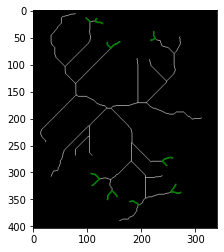

In [87]:

plt.imshow(image, cmap='gray')

for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    start = [ ps[0,1],ps[0,0] ]
    end = [ ps[-1,1],ps[-1,0] ]
    

    if ( (start in endpoint_locations) or (end in endpoint_locations) ): # ------weight < theshold AND endpoints are not nodes
        print('edge found')  
        if graph[s][e]['weight'] < 30:
            print('trim this one')

            ps = graph[s][e]['pts']
            plt.plot(ps[:,1], ps[:,0], 'green')

        else:
            print('nah leave em be')
    else:
        print("no matches")

In [88]:
 # ok now you can remove the necessary edges from the 'graph'

 # then convert the graph back to an image

 # check that the number of midpoints = num edges 

 #but first talk to nare ask her if what you are doing overall is fruitful

 #show the voronoi diagram on the long edges and how it does not bound the edge well as we thought that it would 

# TUESDAY
 # also see if you can clean up the erronious midpoints / voronoi partitions 

#  find skeleton of the skeleton (edges equidistant from the skeletal edges )

edge found
nah leave em be
edge found
trim this one
edge found
trim this one
no matches
edge found
trim this one
no matches
edge found
trim this one
edge found
nah leave em be
edge found
trim this one
no matches
edge found
trim this one
edge found
trim this one
no matches
no matches
edge found
nah leave em be
edge found
nah leave em be
no matches
no matches
no matches
edge found
nah leave em be
no matches
no matches
no matches
edge found
nah leave em be
no matches
no matches
no matches
edge found
nah leave em be
no matches
edge found
nah leave em be
edge found
nah leave em be
no matches
no matches
edge found
trim this one
no matches
no matches
edge found
trim this one
edge found
trim this one
edge found
nah leave em be
no matches
edge found
trim this one
no matches
no matches
edge found
trim this one
edge found
trim this one
edge found
trim this one
no matches
edge found
trim this one
no matches
edge found
trim this one
edge found
nah leave em be
True
26


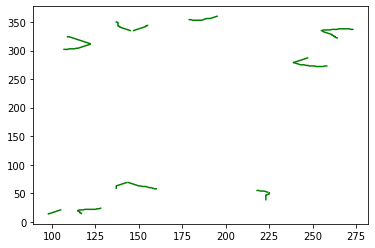

In [89]:
# print(list(graph.nodes()))
# print(graph.edges())
# print(len(trimmed_graph.edges()))
trimmed_graph = copy.deepcopy(graph)
trim_bool = True
# while trim_bool == True :
#     trimmed_graph , trim_bool = trim_edge(trimmed_graph, endpoint_locations , 30)

trimmed_graph , trim_bool = trim_edge(trimmed_graph, endpoint_locations , 30)

print(trim_bool)
print(len(trimmed_graph.edges()))

In [96]:
plt.imshow(image, cmap='gray')
print(trimmed_graph.edges())
for (s,e) in trimmed_graph.edges():
    # if graph[s][e]['weight'] > 30: # ------------------------------------------------- this is to make the small edges not apply 
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')


[(0, 16), (3, 5), (7, 13), (12, 18), (13, 17), (14, 20), (15, 17), (16, 18), (17, 21), (18, 19), (19, 27), (19, 22), (20, 23), (20, 21), (21, 24), (22, 25), (22, 23), (23, 28), (25, 26), (26, 29), (26, 30), (28, 32), (32, 38), (35, 39), (39, 42), (50, 51)]


KeyError: 16

In [91]:
# figure out how to make the trimmed graph

#consider youll need to convert the graph object back into an array of coordinates for the image

In [92]:
# AHHHHHHHHHHHHHHHHHHHHHHHHH F@!# this s!@# im going to make the class object of the graph into a plain coordinate list : list of lists (representing edges) of coordinates (representing actual points)

#or just a plain list

In [93]:
newgraph = []
for (s,e) in graph.edges():
    
    ps = graph[s][e]['pts']
    start = [ ps[0,1],ps[0,0] ]
    end = [ ps[-1,1],ps[-1,0] ]
    print(start,end)
    print(type(start))
    # if graph[s][e]['weight'] < 30 & ( ([ps[0,1],ps[0,0]] in endpoint_locations) or ([ps[-1,1],ps[-1,0]] in endpoint_locations) ): # ------weight < theshold AND endpoints are not nodes
    if ( (start in endpoint_locations) or (end in endpoint_locations) ): # ------weight < theshold AND endpoints are not nodes
        print('edge found')  
        if graph[s][e]['weight'] < 30:
            print('trim this one')
        else:
            print('nah leave em be')
            newgraph.append(graph[s][e]['pts'])
    else:
        print("no matches")
        newgraph.append(graph[s][e]['pts'])



[78, 6] [59, 104]
<class 'list'>
edge found
nah leave em be
[98, 14] [105, 21]
<class 'list'>
edge found
trim this one
[117, 15] [115, 19]
<class 'list'>
edge found
trim this one
[114, 20] [106, 21]
<class 'list'>
no matches
[115, 20] [128, 24]
<class 'list'>
edge found
trim this one
[105, 22] [59, 104]
<class 'list'>
no matches
[223, 39] [225, 51]
<class 'list'>
edge found
trim this one
[272, 49] [261, 80]
<class 'list'>
edge found
nah leave em be
[224, 52] [218, 55]
<class 'list'>
edge found
trim this one
[226, 52] [261, 80]
<class 'list'>
no matches
[160, 58] [144, 69]
<class 'list'>
edge found
trim this one
[137, 59] [143, 69]
<class 'list'>
edge found
trim this one
[143, 70] [79, 135]
<class 'list'>
no matches
[261, 80] [247, 131]
<class 'list'>
no matches
[193, 89] [194, 170]
<class 'list'>
edge found
nah leave em be
[215, 91] [247, 131]
<class 'list'>
edge found
nah leave em be
[59, 104] [78, 135]
<class 'list'>
no matches
[247, 131] [210, 170]
<class 'list'>
no matches
[79, 136


skeleton converted to graph

found image at :  ../MAPS/Lake_Murray_Map_Originals/SouthEastCorner_BW_bianary.png
be sure you are pathing to a skeleton for locate_nodes
(ydim , xdim) ==  (403, 341)
No errors detected
this skeleton has 324904.0 edge lines, 82270 nodes, 3 endpoints, and 0 islands. 
the skeleton is of length 82292 pixels.
the edgelines are of average length 5.847881220298919e-05, .
this function returns total_skeleton, nodes, edges, endpoints, and island's locations in (x,y) coordinate form


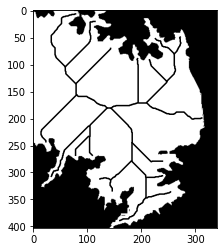

In [94]:
path = r'../MAPS/Lake_Murray_Map_Originals/SouthEastCorner_BW_bianary.png' 
graph = skeleton_to_graph(path)
image = open_image(path) #start by opening the image, choose image in the function 
total_skeleton,node_locations,edge_locations,endpoint_locations,island_locations = locate_nodes(path)

plt.imshow(image, cmap='gray')

# for i in range(0,len(newgraph)):

#     for j in range(0,len(newgraph[i])):
#         plt.plot(newgraph[i][j][0],newgraph[i][j][1],'black' )

for edge in newgraph:
    plt.plot(edge[:,1], edge[:,0], 'black')

